In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms

In [ ]:
# Load and normalize MNIST CSV (0-1)
df = pd.read_csv("mnist_train.csv")
print("Shape (raw):", df.shape)

# first column is label, remaining 784 columns are pixels
label_col = df.columns[0]
X = df.drop(columns=[label_col]).astype(np.float32)
y = df[label_col].astype(np.int64)

# Normalize to [0,1]
X_norm = X / 255.0

print("X_norm shape:", X_norm.shape, "y shape:", y.shape)
print("Min/Max after norm:", float(X_norm.min().min()), float(X_norm.max().max()))

In [ ]:
# First, split off 20% test from the full dataset
X_temp, X_test, y_temp, y_test = train_test_split(
    X_norm, y, test_size=0.20, stratify=y
)

# From the remaining 80%, take 25% as validation (0.25 * 0.80 = 0.20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp
)

print(
    "Shapes ->",
    f"train: {X_train.shape}",
    f"val: {X_val.shape}",
    f"test: {X_test.shape}",
)

In [ ]:
BATCH_SIZE = 64

def make_loader(X, y, batch_size=BATCH_SIZE, shuffle=False):
    tensor_X = torch.tensor(X.values, dtype=torch.float32)
    tensor_y = torch.tensor(y.values, dtype=torch.long)
    ds = TensorDataset(tensor_X, tensor_y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader = make_loader(X_val, y_val)
test_loader = make_loader(X_test, y_test)

print(f"Num train batches: {len(train_loader)}")
print(f"Num val batches: {len(val_loader)}")
print(f"Num test batches: {len(test_loader)}")

In [ ]:
# Filter data to only labels 0 and 1
# Reuse normalized features X_norm and labels y
mask01 = y.isin([0, 1])
X01 = X_norm[mask01].reset_index(drop=True)
y01 = y[mask01].reset_index(drop=True)

print("Shapes (0/1 only):", X01.shape, y01.shape)
print("Class counts:\n", y01.value_counts().sort_index())

In [ ]:
# First, split off 20% test from the full dataset
X_temp_01, X_test_01, y_temp_01, y_test_01 = train_test_split(
    X01, y01, test_size=0.20, stratify=y01
)

# From the remaining 80%, take 25% as validation (0.25 * 0.80 = 0.20 overall)
X_train_01, X_val_01, y_train_01, y_val_01 = train_test_split(
    X_temp_01, y_temp_01, test_size=0.25, stratify=y_temp_01
)

print(
    "Shapes ->",
    f"train: {X_train_01.shape}",
    f"val: {X_val_01.shape}",
    f"test: {X_test_01.shape}",
)

In [ ]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(z)

In [ ]:
BATCH_SIZE_BIN = 64

def make_loader_bin(X_df, y_series, batch_size=BATCH_SIZE_BIN, shuffle=False):
    X_t = torch.tensor(X_df.values, dtype=torch.float32)
    y_t = torch.tensor(y_series.values, dtype=torch.float32).view(-1, 1)  # (N,1)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_01_loader_bin = make_loader_bin(X_train_01, y_train_01, shuffle=True)
val_01_loader_bin = make_loader_bin(X_val_01, y_val_01)
test_01_loader_bin = make_loader_bin(X_test_01, y_test_01)

len(train_01_loader_bin), len(val_01_loader_bin), len(test_01_loader_bin)

In [ ]:
# Torch forward functions: logit and probability
def logit_torch(X: torch.Tensor, W: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return X @ W + b  # (N,1)

def predict_proba(X: torch.Tensor, W: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(logit_torch(X, W, b))

In [ ]:
# Initialize parameters W and b (requires_grad=True)
INPUT_DIM = X_train_01.shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

W = torch.zeros((INPUT_DIM, 1), dtype=torch.float32, requires_grad=True, device=device)
b = torch.zeros((1,), dtype=torch.float32, requires_grad=True, device=device)

In [ ]:
# Binary cross-entropy loss (PyTorch tensors) and manual GD training (lr=0.01)
EPS = 1e-7

def bce_loss(probs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    probs = torch.clamp(probs, EPS, 1.0 - EPS)
    return -(targets * torch.log(probs) + (1.0 - targets) * torch.log(1.0 - probs)).mean()

LR = 0.01
MAX_EPOCHS = 100
PATIENCE = 5

best_val_loss = float("inf")
patience_left = PATIENCE
history = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, MAX_EPOCHS + 1):
    # Train
    W.grad = None
    b.grad = None
    model_train_loss_sum = 0.0
    train_correct = 0
    num_train_samples = 0

    for xb, yb in train_01_loader_bin:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = logit_torch(xb, W, b)
        probs = torch.sigmoid(logits)
        loss = bce_loss(probs, yb)

        loss.backward()
        with torch.no_grad():
            W -= LR * W.grad
            b -= LR * b.grad
            W.grad.zero_()
            b.grad.zero_()

        preds = (probs >= 0.5).float()
        train_correct += (preds == yb).sum().item()

        model_train_loss_sum += loss.item() * xb.size(0)
        num_train_samples += xb.size(0)

    train_loss = model_train_loss_sum / max(1, num_train_samples)
    train_acc = train_correct / max(1, num_train_samples)

    # Validation
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_01_loader_bin:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = logit_torch(xb, W, b)
            probs = torch.sigmoid(logits)
            loss = bce_loss(probs, yb)
            val_loss_sum += loss.item() * xb.size(0)

            preds = (probs >= 0.5).float()
            val_correct += (preds == yb).sum().item()
            val_total += yb.numel()

    val_loss = val_loss_sum / max(1, val_total)
    val_acc = val_correct / max(1, val_total)

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    # Early stopping on val_loss
    if val_loss + 1e-5 < best_val_loss:
        best_val_loss = val_loss
        patience_left = PATIENCE
    else:
        patience_left -= 1
        if patience_left == 0:
            print("Early stopping: no improvement in validation loss.")
            break
        
history

In [ ]:
# Plot training/validation loss and accuracy curves
epochs = history["epoch"]
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Final test accuracy and confusion matrix
model_test_correct = 0
model_test_total = 0
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_01_loader_bin:
        xb = xb.to(device)
        yb = yb.to(device)
        probs = torch.sigmoid(logit_torch(xb, W, b))
        preds = (probs >= 0.5).float()
        model_test_correct += (preds == yb).sum().item()
        model_test_total += yb.numel()

        all_true.append(yb.cpu())
        all_pred.append(preds.cpu())

y_true = torch.vstack(all_true).numpy().ravel()
y_pred = torch.vstack(all_pred).numpy().ravel()

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("Confusion Matrix (rows: true, cols: pred):\n", cm)
acc, cm


In [90]:
# Softmax regression from scratch (NumPy) — single cell (LR=0.01, full-batch GD)
import numpy as np

# Data
X_train_np = X_train.values.astype(np.float32)
X_val_np   = X_val.values.astype(np.float32)
X_test_np  = X_test.values.astype(np.float32)

y_train_np = y_train.values.astype(np.int64)
y_val_np   = y_val.values.astype(np.int64)
y_test_np  = y_test.values.astype(np.int64)

N, D = X_train_np.shape
C = int(max(y_train_np.max(), y_val_np.max(), y_test_np.max()) + 1)

# Helpers
def softmax_np(logits: np.ndarray) -> np.ndarray:
    z = logits - logits.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy_np(y_true: np.ndarray, probs: np.ndarray) -> float:
    eps = 1e-12
    p = np.clip(probs, eps, 1.0)
    return float(np.mean(-np.log(p[np.arange(y_true.shape[0]), y_true])))

def one_hot(y: np.ndarray, C: int) -> np.ndarray:
    out = np.zeros((y.shape[0], C), dtype=np.float32)
    out[np.arange(y.shape[0]), y] = 1.0
    return out

y_train_oh = one_hot(y_train_np, C)

# Params and training setup
LR = 0.01
MAX_EPOCHS = 2000
TOL = 1e-6
PATIENCE = 5

W_np = np.zeros((D, C), dtype=np.float32)
b_np = np.zeros((C,), dtype=np.float32)

best_val = float("inf"); best_W = W_np.copy(); best_b = b_np.copy(); pat = PATIENCE
history_np = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, MAX_EPOCHS + 1):
    # Forward
    logits_tr = X_train_np @ W_np + b_np
    probs_tr = softmax_np(logits_tr)
    train_loss = cross_entropy_np(y_train_np, probs_tr)

    # Gradients
    grad_logits = (probs_tr - y_train_oh) / N
    grad_W = X_train_np.T @ grad_logits
    grad_b = grad_logits.sum(axis=0)

    # Update
    W_np -= LR * grad_W
    b_np -= LR * grad_b

    # Validation
    logits_val = X_val_np @ W_np + b_np
    probs_val = softmax_np(logits_val)
    val_loss = cross_entropy_np(y_val_np, probs_val)

    # Metrics
    tr_acc = float((probs_tr.argmax(axis=1) == y_train_np).mean())
    va_acc = float((probs_val.argmax(axis=1) == y_val_np).mean())

    history_np["epoch"].append(epoch)
    history_np["train_loss"].append(train_loss)
    history_np["val_loss"].append(val_loss)
    history_np["train_acc"].append(tr_acc)
    history_np["val_acc"].append(va_acc)

    # Early stopping
    if val_loss + 1e-12 < best_val - TOL:
        best_val = val_loss; best_W = W_np.copy(); best_b = b_np.copy(); pat = PATIENCE
    else:
        pat -= 1
        if pat == 0:
            break

# Best params and test preds
W_np, b_np = best_W, best_b
y_pred_np_test = (X_test_np @ W_np + b_np).argmax(axis=1)
y_true_np_test = y_test_np.copy()


In [91]:
# PyTorch softmax regression — single cell (LR=0.01, full-batch GD)
import torch
import torch.nn as nn

# Data (CPU)
X_train_t = torch.tensor(X_train.values.astype(np.float32))
y_train_t = torch.tensor(y_train.values.astype(np.int64))
X_val_t   = torch.tensor(X_val.values.astype(np.float32))
y_val_t   = torch.tensor(y_val.values.astype(np.int64))
X_test_t  = torch.tensor(X_test.values.astype(np.float32))
y_test_t  = torch.tensor(y_test.values.astype(np.int64))

N_t, D_t = X_train_t.shape
C_t = int(max(y_train_t.max().item(), y_val_t.max().item(), y_test_t.max().item()) + 1)

# Model
model_t = nn.Linear(D_t, C_t, bias=True)
with torch.no_grad():
    model_t.weight.zero_(); model_t.bias.zero_()

criterion = nn.CrossEntropyLoss()
LR = 0.01
MAX_EPOCHS = 2000
TOL = 1e-6
PATIENCE = 5

best_val = float('inf')
best_state = {k: v.clone() for k, v in model_t.state_dict().items()}
pat = PATIENCE

history_t = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def acc_t(logits: torch.Tensor, y: torch.Tensor) -> float:
    return float((logits.argmax(dim=1) == y).float().mean().item())

for epoch in range(1, MAX_EPOCHS + 1):
    logits_tr = model_t(X_train_t)
    loss_tr = criterion(logits_tr, y_train_t)

    for p in model_t.parameters():
        if p.grad is not None: p.grad.zero_()
    loss_tr.backward()
    with torch.no_grad():
        for p in model_t.parameters():
            p -= LR * p.grad

    with torch.no_grad():
        logits_val = model_t(X_val_t)
        loss_val = criterion(logits_val, y_val_t)

    tr_acc = acc_t(logits_tr, y_train_t)
    va_acc = acc_t(logits_val, y_val_t)

    history_t["epoch"].append(epoch)
    history_t["train_loss"].append(float(loss_tr.item()))
    history_t["val_loss"].append(float(loss_val.item()))
    history_t["train_acc"].append(tr_acc)
    history_t["val_acc"].append(va_acc)

    if loss_val.item() + 1e-12 < best_val - TOL:
        best_val = loss_val.item(); best_state = {k: v.clone() for k, v in model_t.state_dict().items()}; pat = PATIENCE
    else:
        pat -= 1
        if pat == 0:
            break

model_t.load_state_dict(best_state)

# Test predictions
y_pred_t_test = model_t(X_test_t).argmax(dim=1).cpu().numpy()
y_true_t_test = y_test_t.cpu().numpy()


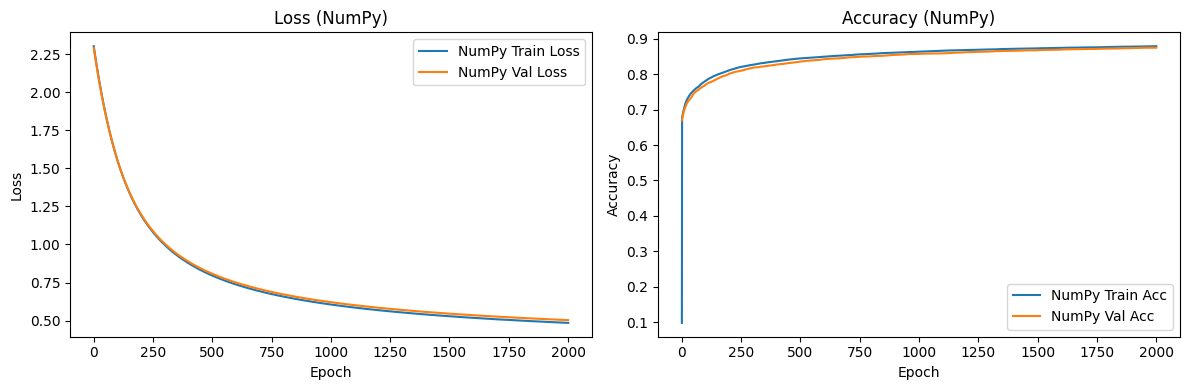

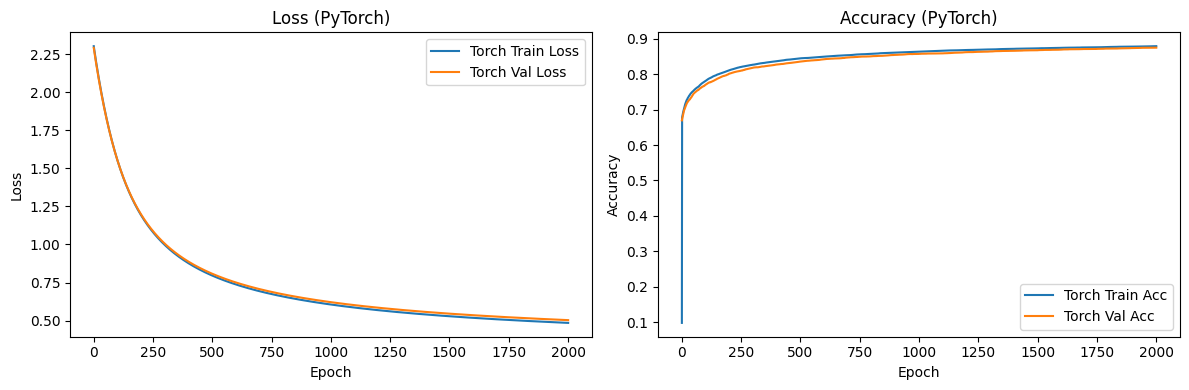

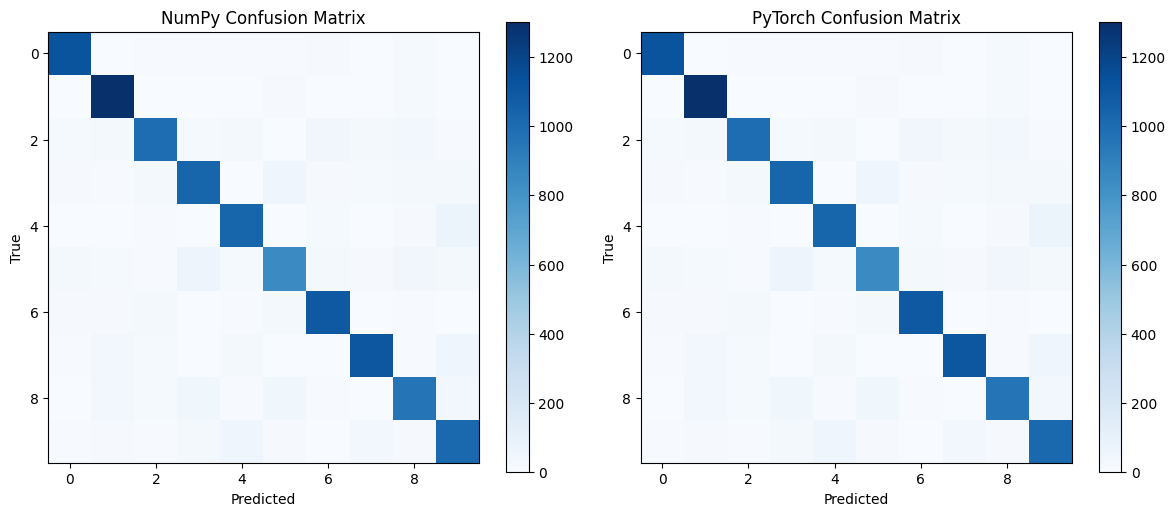

NumPy per-class accuracy:
Class 0: 0.9451  (1120/1185)
Class 1: 0.9644  (1300/1348)
Class 2: 0.8322  (992/1192)
Class 3: 0.8418  (1032/1226)
Class 4: 0.8853  (1034/1168)
Class 5: 0.7795  (845/1084)
Class 6: 0.9248  (1095/1184)
Class 7: 0.8835  (1107/1253)
Class 8: 0.8179  (957/1170)
Class 9: 0.8529  (1015/1190)

PyTorch per-class accuracy:
Class 0: 0.9451  (1120/1185)
Class 1: 0.9644  (1300/1348)
Class 2: 0.8322  (992/1192)
Class 3: 0.8418  (1032/1226)
Class 4: 0.8853  (1034/1168)
Class 5: 0.7795  (845/1084)
Class 6: 0.9248  (1095/1184)
Class 7: 0.8835  (1107/1253)
Class 8: 0.8179  (957/1170)
Class 9: 0.8529  (1015/1190)


In [92]:
# Deliverables: plots (train/val), confusion matrices, per-class accuracies for NumPy and PyTorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 1) Training/Validation plots
plt.figure(figsize=(12,4))
# NumPy loss/acc
plt.subplot(1,2,1)
plt.plot(history_np["epoch"], history_np["train_loss"], label="NumPy Train Loss")
plt.plot(history_np["epoch"], history_np["val_loss"], label="NumPy Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss (NumPy)"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_np["epoch"], history_np["train_acc"], label="NumPy Train Acc")
plt.plot(history_np["epoch"], history_np["val_acc"], label="NumPy Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy (NumPy)"); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
# PyTorch loss/acc
plt.subplot(1,2,1)
plt.plot(history_t["epoch"], history_t["train_loss"], label="Torch Train Loss")
plt.plot(history_t["epoch"], history_t["val_loss"], label="Torch Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss (PyTorch)"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_t["epoch"], history_t["train_acc"], label="Torch Train Acc")
plt.plot(history_t["epoch"], history_t["val_acc"], label="Torch Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy (PyTorch)"); plt.legend()
plt.tight_layout(); plt.show()

# 2) Test Confusion Matrices
cm_np = confusion_matrix(y_true_np_test, y_pred_np_test)
cm_t  = confusion_matrix(y_true_t_test, y_pred_t_test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(cm_np, cmap=plt.cm.Blues); plt.title("NumPy Confusion Matrix"); plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.subplot(1,2,2)
plt.imshow(cm_t, cmap=plt.cm.Blues); plt.title("PyTorch Confusion Matrix"); plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 3) Per-class accuracy
def per_class_acc(y_true, y_pred, C):
    counts = np.zeros(C, dtype=np.int64)
    correct = np.zeros(C, dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        counts[t] += 1
        if t == p: correct[t] += 1
    return np.divide(correct, np.maximum(1, counts)), counts, correct

accs_np, counts_np, correct_np = per_class_acc(y_true_np_test, y_pred_np_test, cm_np.shape[0])
accs_t,  counts_t,  correct_t  = per_class_acc(y_true_t_test,  y_pred_t_test,  cm_t.shape[0])

print("NumPy per-class accuracy:")
for c in range(cm_np.shape[0]):
    print(f"Class {c}: {accs_np[c]:.4f}  ({correct_np[c]}/{counts_np[c]})")

print("\nPyTorch per-class accuracy:")
for c in range(cm_t.shape[0]):
    print(f"Class {c}: {accs_t[c]:.4f}  ({correct_t[c]}/{counts_t[c]})")
